In [91]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

df = get_data_index("r1") # all RAM subjects
exp = 'FR1'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Plot CA3 v. DG on same plot

CA1: 3211 recalls
Test 1 p-value: 0.8551984742479201
Test 2 p-value: 0.8407443735077846
Dentate gyrus: 2397 recalls
Test 1 p-value: 0.6640347671201461
Test 2 p-value: 0.9461553452498093


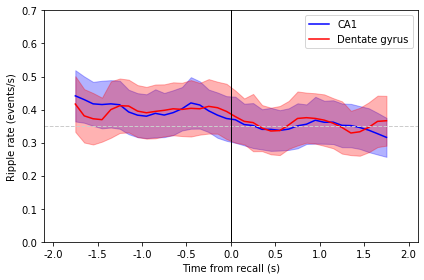

In [129]:
# load data from each

selected_period = 'surrounding_recall' 
remove_soz_ictal = False
recall_type_switch = 1 # 0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls
region_name = 'HPC'
# location_selected = 'ca1' # 'ca3' # 'dg' 'ca1' # sub # left hippocampus # right hippocampus # hippocampus
# # (leave as '' if not HPC)

pad = 2
psth_start = -2000
psth_end = 2000
stats_bin = 500 # time bin width in ms to test stats on
first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

# get strings for path name for save and loading cluster data
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period)

for p,location_selected in enumerate(['ca1','dg']):
    
    if p==0:
        subplots(1,1,figsize=(6,4)); ax = plt.gca()
        color = (0,0,1)
        label = 'CA1'
        line_dist = 0.175
    else:
        color = (1,0,0)
        label = 'Dentate gyrus'
        line_dist = 0.15

    path_name = '/home1/john/SWR/figures/'+subfolder
    fn = os.path.join(path_name,
        'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+'.p')            
    with open(fn,'rb') as f:
        dat = pickle.load(f)
        bin_centers = dat['bin_centers']; PSTH = dat['PSTH']; CI_plot = dat['CI_plot']; num_trials = dat['num_trials'];
        bin_model1 = dat['bin_model1']; bin_model2 = dat['bin_model2']

    # make plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)

    # plot smoothed mean +/- CI
    if pad > 0:
        plot(xr[pad:-pad],PSTH[pad:-pad],color=color)
        fill_between(xr[pad:-pad], PSTH[pad:-pad]-CI_plot[0,:], PSTH[pad:-pad]+CI_plot[0,:],
                     color=color, alpha = 0.3, label='_nolegend_')
    else:
        plot(xr,PSTH)
        fill_between(xr, PSTH-CI_plot[0,:], PSTH+CI_plot[0,:],
                     color=color, alpha = 0.3, label='_nolegend_')

    # plot bands of significance
    if bin_model1.pvalues[1] < 0.05:
        plot([first_end-stats_bin,first_end],[line_dist,line_dist],'--',
             color=color,label='_nolegend_')
    if bin_model2.pvalues[1] < 0.05:
        plot([second_start,second_start+stats_bin],[line_dist,line_dist],'--',
             color=color,label='_nolegend_')
    print(label+': '+str(num_trials)+' recalls')
    print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
    print('Test 2 p-value: '+str(bin_model2.pvalues[1]))

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
xlabel('Time from recall (s)')
ylabel('Ripple rate (events/s)')
ylim = 0.7 # keep it here since occasionally CIs get kinda high
ax.set_ylim(0,ylim)
ax.set_xlim(psth_start-100,psth_end+100)
plot([ax.get_xlim()[0],ax.get_xlim()[1]],[0.35,0.35],linewidth=1,linestyle='--',color=(0.8,0.8,0.8),label='_nolegend_')
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0),label='_nolegend_')
ax.legend({'CA1','Dentate gyrus'})
tight_layout()
plt.show()
a=1;
a=1;

## Single data plots

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2ae25e556d10>)

Entorhinal cortex: 2339 recalls
Test 1 p-value: 0.8569387283456839
Test 2 p-value: 0.1603935450583852


([<matplotlib.axis.XTick at 0x2ae25e147b10>,
 <a list of 9 Text xticklabel objects>)

Text(0.5, 0, 'Time from recall (s)')

Text(0, 0.5, 'Ripple rate (events/s)')

(0, 0.7)

(-2100, 2100)

Entorhinal cortex: 2339 recalls
Test 1 p-value: 0.8569387283456839
Test 2 p-value: 0.1603935450583852


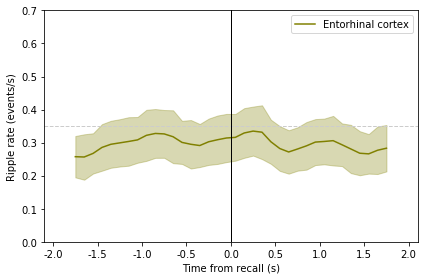

In [128]:
# load data from each

selected_period = 'surrounding_recall' 
remove_soz_ictal = False
recall_type_switch = 0 # 0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls
region_name = 'ENT' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC 
location_selected = '' #'ca1' # 'ca3' # 'dg' 'ca1' # sub # left hippocampus # right hippocampus # hippocampus
# # (leave as '' if not HPC)

legend_name = 'Entorhinal cortex' #'Parahippocampal cortex' #'Entorhinal'
color = (0.5,0.5,0) # (0.5,0.5,0)
line_dist = 0.175

pad = 2
psth_start = -2000
psth_end = 2000
stats_bin = 500 # time bin width in ms to test stats on
first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

# get strings for path name for save and loading cluster data
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period)

subplots(1,1,figsize=(6,4)); ax2 = plt.gca()

path_name = '/home1/john/SWR/figures/'+subfolder
fn = os.path.join(path_name,
    'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+'.p')            
with open(fn,'rb') as f:
    dat = pickle.load(f)
    bin_centers = dat['bin_centers']; PSTH = dat['PSTH']; CI_plot = dat['CI_plot']; num_trials = dat['num_trials'];
    bin_model1 = dat['bin_model1']; bin_model2 = dat['bin_model2']

# make plot
xr = bin_centers #np.arange(psth_start,psth_end,binsize)

# plot smoothed mean +/- CI
if pad > 0:
    plot(xr[pad:-pad],PSTH[pad:-pad],color=color);
    fill_between(xr[pad:-pad], PSTH[pad:-pad]-CI_plot[0,:], PSTH[pad:-pad]+CI_plot[0,:],
                 color=color, alpha = 0.3, label='_nolegend_');
else:
    plot(xr,PSTH);
    fill_between(xr, PSTH-CI_plot[0,:], PSTH+CI_plot[0,:],
                 color=color, alpha = 0.3, label='_nolegend_');

# plot bands of significance
if bin_model1.pvalues[1] < 0.05:
    plot([first_end-stats_bin,first_end],[line_dist,line_dist],'--',
         color=color,label='_nolegend_');
if bin_model2.pvalues[1] < 0.05:
    plot([second_start,second_start+stats_bin],[line_dist,line_dist],'--',
         color=color,label='_nolegend_');
print(legend_name+': '+str(num_trials)+' recalls')
print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
print('Test 2 p-value: '+str(bin_model2.pvalues[1]))

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
xlabel('Time from recall (s)')
ylabel('Ripple rate (events/s)')
ylim = 0.7 # keep it here since occasionally CIs get kinda high
ax2.set_ylim(0,ylim)
ax2.set_xlim(psth_start-100,psth_end+100)
plot([ax2.get_xlim()[0],ax2.get_xlim()[1]],[0.35,0.35],linewidth=1,linestyle='--',color=(0.8,0.8,0.8),label='_nolegend_')
plot([0,0],[ax2.get_ylim()[0],ax2.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0),label='_nolegend_')
plt.legend({legend_name})
tight_layout()
print(legend_name+': '+str(num_trials)+' recalls')
print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
print('Test 2 p-value: '+str(bin_model2.pvalues[1]))
a=1;
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period)

# Comparison plots for clustering

upper: 6965 recalls
Test 1 p-value: 2.439383098091856e-14
Test 2 p-value: 8.344650892138803e-06
lower: 7530 recalls
Test 1 p-value: 1.016124503736313e-07
Test 2 p-value: 0.0003959576039842492


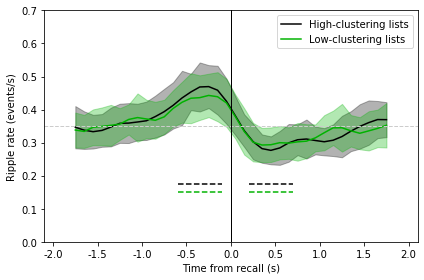

In [138]:
# load data from each

selected_period = 'surrounding_recall' 
remove_soz_ictal = False
recall_type_switch = 3 # 0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls
region_name = 'HPC'
# location_selected = 'ca1' # 'ca3' # 'dg' 'ca1' # sub # left hippocampus # right hippocampus # hippocampus
# # (leave as '' if not HPC)

min_recalls = 3 # minimum recalls/list

pad = 2
psth_start = -2000
psth_end = 2000
stats_bin = 500 # time bin width in ms to test stats on
first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

# get strings for path name for save and loading cluster data
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period)

for p,upper_label in enumerate(['upper','lower']):
    
    location_selected = ''
    if p==0:
        subplots(1,1,figsize=(6,4)); ax = plt.gca()
        color = (0,0,0)
        line_dist = 0.175
    else:
        color = (0,0.7,0)
        line_dist = 0.15

    path_name = '/home1/john/SWR/figures/'+subfolder
    fn = os.path.join(path_name,
        'SWRCLUSTER_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+
                      '_'+soz_label+'_recalls-'+str(min_recalls)+'_'+upper_label+'.p')          
    with open(fn,'rb') as f:
        dat = pickle.load(f)
        bin_centers = dat['bin_centers']; PSTH = dat['PSTH']; CI_plot = dat['CI_plot']; num_trials = dat['num_trials'];
        bin_model1 = dat['bin_model1']; bin_model2 = dat['bin_model2']

    # make plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)

    # plot smoothed mean +/- CI
    if pad > 0:
        plot(xr[pad:-pad],PSTH[pad:-pad],color=color)
        fill_between(xr[pad:-pad], PSTH[pad:-pad]-CI_plot[0,:], PSTH[pad:-pad]+CI_plot[0,:],
                     color=color, alpha = 0.3, label='_nolegend_')
    else:
        plot(xr,PSTH)
        fill_between(xr, PSTH-CI_plot[0,:], PSTH+CI_plot[0,:],
                     color=color, alpha = 0.3, label='_nolegend_')

    # plot bands of significance
    if bin_model1.pvalues[1] < 0.05:
        plot([first_end-stats_bin,first_end],[line_dist,line_dist],'--',
             color=color,label='_nolegend_')
    if bin_model2.pvalues[1] < 0.05:
        plot([second_start,second_start+stats_bin],[line_dist,line_dist],'--',
             color=color,label='_nolegend_')
    print(upper_label+': '+str(num_trials)+' recalls')
    print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
    print('Test 2 p-value: '+str(bin_model2.pvalues[1]))

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
xlabel('Time from recall (s)')
ylabel('Ripple rate (events/s)')
ylim = 0.7 # keep it here since occasionally CIs get kinda high
ax.set_ylim(0,ylim)
ax.set_xlim(psth_start-100,psth_end+100)
plot([ax.get_xlim()[0],ax.get_xlim()[1]],[0.35,0.35],linewidth=1,linestyle='--',color=(0.8,0.8,0.8),label='_nolegend_')
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0),label='_nolegend_')
ax.legend({'High-clustering lists','Low-clustering lists'})
tight_layout()
plt.show()
a=1;